In [29]:
import pandas as pd
import numpy as np
import seaborn as sns
import seaborn.objects as so
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import plotly.express as px
import datetime
from sklearn.preprocessing import MinMaxScaler
from shapely.geometry import Polygon, MultiPolygon, Point
from sklearn.utils import resample
import warnings
warnings.filterwarnings('ignore')

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)
#pd.set_option('display.precision', 2)
pd.set_option('display.float_format', '{:.2f}'.format)

### Load in data

In [3]:
fire = pd.read_csv('C:\\Users\\Taavi\\Downloads\\rawFire.csv')
crime = pd.read_csv('C:\\Users\\Taavi\\Downloads\\rawCrime.csv')
sales = pd.read_csv('C:\\Users\\Taavi\\Downloads\\rawSales.csv')
viols = pd.read_csv('C:\\Users\\Taavi\\Downloads\\rawViols.csv')
parcels = pd.read_csv('C:\\Users\\Taavi\\Downloads\\rawParcels.csv')

In [4]:
parcels.head(3)

,parcelID,lat,lng
0,0001D00023005A00,40.44,-80.00
1,0088C00010000000,40.42,-79.92
2,0055P00349000000,40.42,-79.94


### Undersample parcels df to reduce computational intensity (rather than work 144k parcels, just work with 10k)

In [5]:
np.random.seed(42)
parcels = parcels.sample(10000)

### Functions to:
1) construct a 50m radius around each parcel - for this analysis we're only going to run this for one parcel
2) tally events within 50m radius of each parcel
3) calculate average value of sales withim 50m raidus of each parcel

In [6]:
def construct_perimeter(parcels, r):
    x_vals = [i for i in range(0, r + 1, 1)]
    y_vals = []

    for x in x_vals:
        y = np.sqrt( (r ** 2) - (x ** 2) )
        y_vals.append(y)
        pass
    
    conversionVector = np.array([85500, 111111.111])
    coords1 = np.array([[i, j] for i, j in zip(x_vals, y_vals)]) / conversionVector
    coords2 = coords1 * np.array([-1, 1])
    coords3 = coords1 * np.array([-1, -1])
    coords4 = coords1 * np.array([1, -1])
    
    polyX_vals = []

    for index, row in parcels.iterrows():
        origin = np.array([row['lng'], row['lat']])
        coordsX_1 = origin + coords1
        coordsX_2 = origin + coords2
        coordsX_3 = origin + coords3
        coordsX_4 = origin + coords4
        coordsX = np.concatenate((coordsX_1, coordsX_2, coordsX_3, coordsX_4))
        polyX = Polygon(coordsX)
        polyX_vals.append(polyX)
        pass
    
    return polyX_vals

In [7]:
def tally_events(parcels, data, r):

    numEvents_vals = []

    for index, row in parcels.iterrows():
        numEvents = 0
        polygon = row['radius' + str(r)]

        df = data.copy()
        
        if len(df) > 1000:
            df = resample(df, replace = False, n_samples = 1000, random_state = 42)
        else:
            pass

        for indexj, rowj in df.iterrows():
            point = Point(rowj['lng'], rowj['lat'])

            if point.within(polygon):
                numEvents += 1
            else:
                pass

        numEvents_vals.append(numEvents)
        pass

    return numEvents_vals

In [8]:
def calc_avgValue(parcels, data, r):
    
    avgValue_vals = []

    for index, row in parcels.iterrows():
        numVals = 0
        sumVals = 0
        polygon = row['radius' + str(r)]\

        df = data.copy()
        if len(df) > 5000:
            df = resample(df, replace = False, n_samples = 5000, random_state = 42)
        else:
            pass

        for indexj, rowj in df.iterrows():
            point = Point(rowj['lng'], rowj['lat'])

            if point.within(polygon):
                numVals += 1
                sumVals += rowj['salePrice']
            else:
                pass
            pass
        
        if numVals > 0:
            avgValue = sumVals / numVals
            pass
        else:
            avgValue = None

        avgValue_vals.append(avgValue)
        pass

    return avgValue_vals

### Save down one random parcel to construct a 50m radius around later - for visualization purposes

In [9]:
np.random.seed(42)
oneParcel = parcels.sample(1)
oneParcel.to_csv('C:\\Users\\Taavi\\Downloads\\oneParcel.csv', index = False)

### Select a relevant time range

In [10]:
fire['date'].min(), fire['date'].max()

('2013-01', '2024-09')

In [11]:
crime['date'].min(), crime['date'].max()

('1992-12', '2023-11')

In [12]:
viols['date'].min(), viols['date'].max()

('2015-10', '2024-09')

In [13]:
sales['date'].min(), sales['date'].max()

('1797-09', '2024-08')

### Selecting 2016 - 2022

In [14]:
fire['date'] = pd.to_datetime(fire['date'])
crime['date'] = pd.to_datetime(crime['date'])
viols['date'] = pd.to_datetime(viols['date'])
sales['date'] = pd.to_datetime(sales['date'])

fire_subset = fire.loc[(fire['date'].dt.year >= 2016) & (fire['date'].dt.year <= 2022)]
crime_subset = crime.loc[(crime['date'].dt.year >= 2016) & (crime['date'].dt.year <= 2022)]
viols_subset = viols.loc[(viols['date'].dt.year >= 2016) & (viols['date'].dt.year <= 2022)]
sales_subset = sales.loc[(sales['date'].dt.year >= 2016) & (sales['date'].dt.year <= 2022)]
# remove sales for < $100 ("love and affection sales")
sales_subset = sales_subset.loc[sales_subset['salePrice'] > 100]

### Construct 500m radius perimeters around each parcel

In [20]:
parcels['radius500'] = construct_perimeter(parcels, 500)

### Tally events and calculate average sales within 500m of each parcel, each year

In [21]:
# # this cell takes forever to run - I'm gonna save it down as a csv after
parcels['numFires'] = tally_events(parcels, fire_subset, 500)
print('fire done')
parcels['numCrimes'] = tally_events(parcels, crime_subset, 500)
print('crime done')
parcels['numViols'] = tally_events(parcels, viols_subset, 500)
print('viols done')
parcels['meanSales'] = calc_avgValue(parcels, sales_subset, 500)
print('sales done')

parcels.drop(columns = 'radius500').to_csv('C:\\Users\\Taavi\\Downloads\\parcelsProcessed.csv', index = False)

fire done
crime done
viols done
sales done


In [30]:
parcels = pd.read_csv('C:\\Users\\Taavi\\Downloads\\parcelsProcessed.csv')
oneParcel = pd.read_csv('C:\\Users\\Taavi\\Downloads\\oneParcel.csv')

### Visualizing a parcel and its and 50m radius

In [31]:
# decomposing radius polygon into distinct data points
oneParcel['radius100'] = construct_perimeter(oneParcel, 500)
perimeterCoords = pd.DataFrame(oneParcel['radius100'].values[0].exterior.xy).T.rename(columns = {0: 'lng', 1: 'lat'})
toPlot = pd.concat([oneParcel[['lng', 'lat']], perimeterCoords], axis = 0)

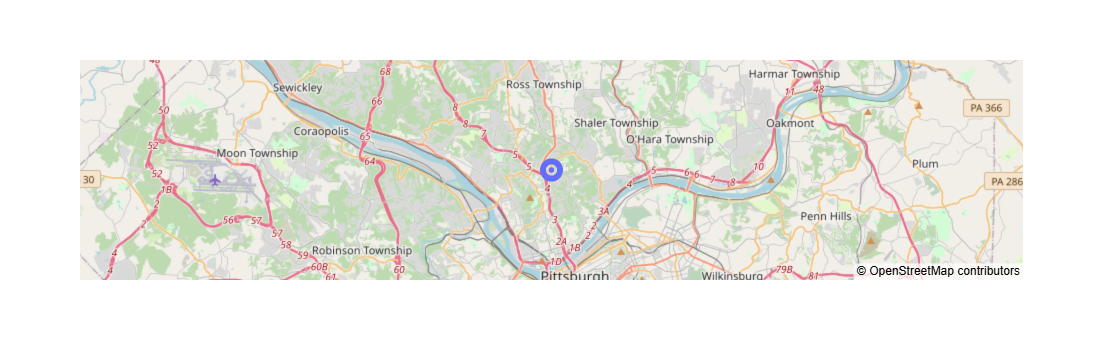

In [32]:
fig = px.scatter_mapbox(toPlot, lat = 'lat', lon = 'lng', zoom = 10)
fig.update_layout(mapbox_style = 'open-street-map')
fig.show()

### MinMax scale event columns
This isn't really necessary for meanSales but we'll do it anyway to be consistent

In [33]:
parcels

,parcelID,lat,lng,numFires,numCrimes,numViols,meanSales
0,0049F00022000000,40.47,-79.96,7,12,11,318469.25
1,0174B00241000000,40.46,-79.89,24,12,23,38169.64
2,0002D00182000001,40.44,-79.99,17,14,5,1949335.53
3,0041F00270000000,40.45,-80.06,3,2,4,102895.00
4,0096K00078000000,40.39,-80.01,3,10,5,137125.08
...,...,...,...,...,...,...,...
9995,0026C00221000000,40.46,-79.96,7,7,9,265347.89
9996,0047P00219000000,40.46,-79.99,7,5,2,82291.90
9997,0096M00235000000,40.39,-80.00,2,1,8,160223.30
9998,0046P00104000000,40.46,-80.01,10,10,9,67693.24


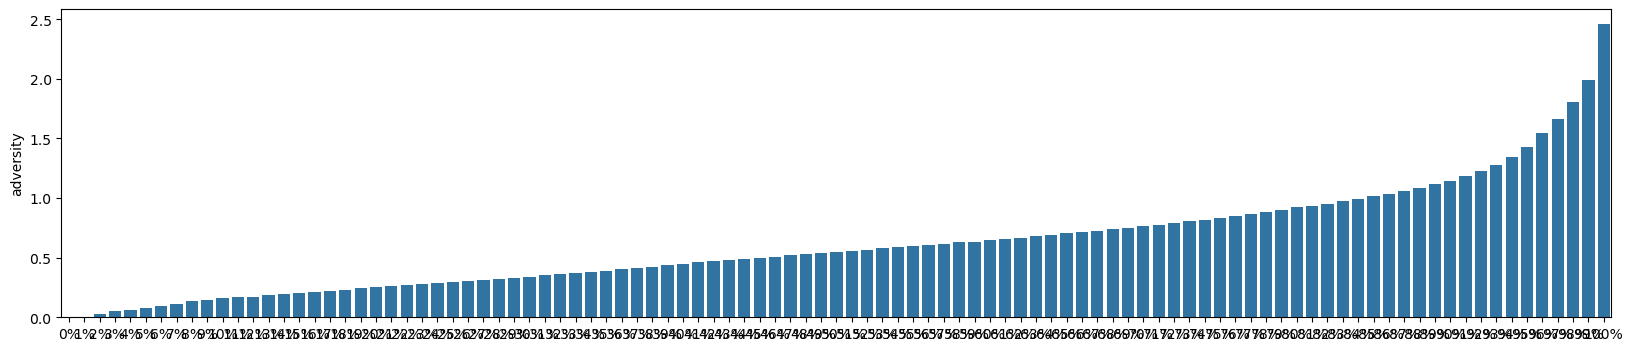

In [36]:
plt.figure(figsize = (20, 4))
sns.barplot(parcels['adversity'].describe(percentiles = np.arange(0, 1.01, 0.01)).iloc[4:-1])
plt.show()

In [34]:
minmax = MinMaxScaler()

eventCols = parcels.iloc[:, -4:]
eventCols_scaled = pd.DataFrame(minmax.fit_transform(eventCols), columns = eventCols.columns)

parcels = pd.concat([parcels.iloc[:, :-4], eventCols_scaled], axis = 1)

### Sum numFires, numCrimes, and numViols as 'adversity' - rename meanSales to 'affluence'

In [35]:
parcels['adversity'] = parcels['numFires'] + parcels['numCrimes'] + parcels['numViols']
parcels = parcels.rename(columns = {'meanSales': 'affluence'})

# trim off unwanted columns
parcels = parcels[['lat', 'lng', 'adversity', 'affluence']]

### Bucket adversity and affluence columns into quartiles

In [37]:
def sort_quadrant(x, q1, q2, q3):
    q = 0
    if x <= q1:
        q = '1'
    elif x <= q2:
        q = '2'
    elif x <= q3:
        q = '3'
    else:
        q = '4'
    return q

In [38]:
q1Adv, q2Adv, q3Adv = parcels['adversity'].describe()[4], parcels['adversity'].describe()[5], parcels['adversity'].describe()[6]
q1Aff, q2Aff, q3Aff = parcels['affluence'].describe()[4], parcels['affluence'].describe()[5], parcels['affluence'].describe()[6]

# sort
parcels['adversity'] = parcels['adversity'].apply(lambda x: sort_quadrant(x, q1Adv, q2Adv, q3Adv))
parcels['affluence'] = parcels['affluence'].apply(lambda x: sort_quadrant(x, q1Aff, q2Aff, q3Aff))

### Visualize adversity and affluence in Pittsburgh

In [43]:
discrete_color_map = {
    '1': '#003f5c',
    '2': '#2f4b7c',
    '3': '#665191',
    '4': '#a05195'
}

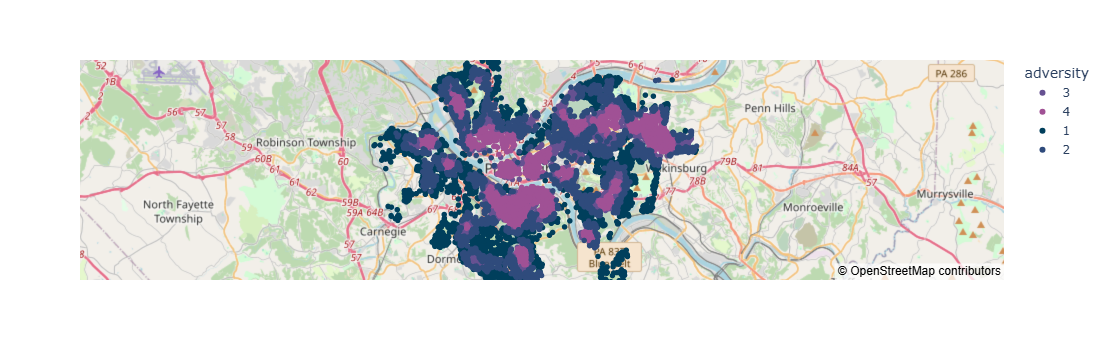

In [50]:
# adversity
fig = px.scatter_mapbox(parcels, lat = 'lat', lon = 'lng', zoom = 10, color = 'adversity', color_discrete_map = discrete_color_map)
fig.update_layout(mapbox_style = 'open-street-map')
fig.show()

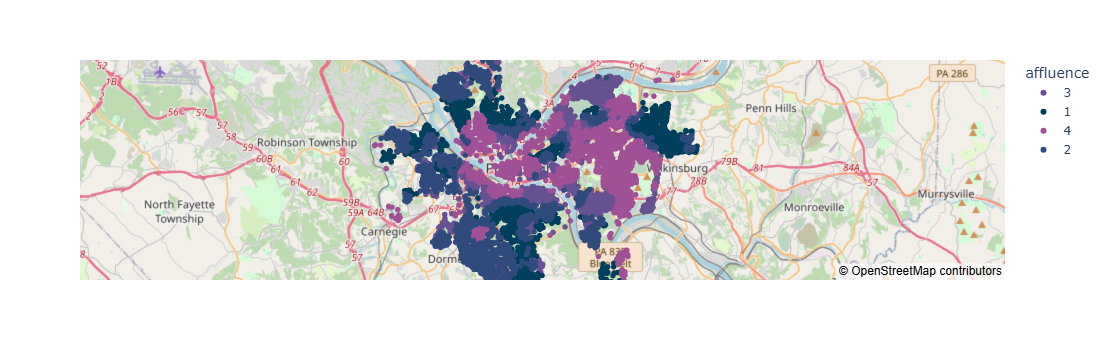

In [49]:
# affluence
fig = px.scatter_mapbox(parcels, lat = 'lat', lon = 'lng', zoom = 10, color = 'affluence', color_discrete_map = discrete_color_map)
fig.update_layout(mapbox_style = 'open-street-map')
fig.show()

### Insight:
In the first visual (Adversity), neighborhoods to the East tend to have low Adversity, with a couple exceptions in the Northeast. In the second visual (Affluence), a lot of those same areas are shown to be highly Affluent, again with the reverse being true for the occasional pocket in the Northeast.

South of the Monongahela River, 